In [27]:
# Essential libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import folium
from folium.plugins import MarkerCluster
import branca.colormap as cm
from geopy.geocoders import Nominatim
import time
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import zscore



# Download NLTK resources
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
from google.colab import files


# Upload the file manually
uploaded = files.upload()  # This will open a file dialog

# Use the exact name of the uploaded file
filename = 'Park_Review_with_ZipCodes.csv'

# Read the file
Park_review = pd.read_csv(filename, encoding='utf-8-sig')
Park_review.columns = Park_review.columns.str.strip()

# Show column names
print(Park_review.columns.tolist())


Saving Park_Review_with_ZipCodes.csv to Park_Review_with_ZipCodes (1).csv
['Name', 'Date', 'Review', 'Park Name', 'Zip Code']


In [29]:
# Load the park review dataset and clean column names
#Park_review = pd.read_csv('/Users/joeyposillico/Desktop/Park_Review_with_ZipCodes.csv', encoding='utf-8-sig')
#Park_review.columns = Park_review.columns.str.strip()
#print(Park_review.columns.tolist())

In [30]:
# 🧼 Remove rows with missing essential data & reset index
pr_cleaned = Park_review.dropna(subset=['Name', 'Date', 'Review', 'Park Name', 'Zip Code'])
pr_cleaned.reset_index(drop=True, inplace=True)

In [31]:
# 📊 Count number of reviews per ZIP code
zip_counts_df = pr_cleaned['Zip Code'].value_counts().reset_index()
zip_counts_df.columns = ['Zip Code', 'Review Count']
zip_counts_df['Zip Code'] = zip_counts_df['Zip Code'].astype(int).astype(str)


In [32]:
# Extract ZIP codes from the review data and preview the structure
zip_codes_of_interest = zip_counts_df['Zip Code'].tolist()
print(zip_counts_df)
print(zip_counts_df.columns)

   Zip Code  Review Count
0     28202           664
1     28203           380
2     28216           378
3     28210           269
4     28205           262
5     28226           248
6     28269           215
7     28215           214
8     28262           194
9     28078           181
10    28217           120
Index(['Zip Code', 'Review Count'], dtype='object')


In [34]:
# Upload the GeoJSON file
uploaded = files.upload()

# Replace with the actual uploaded filename
geojson_file = 'nc_north_carolina_zip_codes_geo.min.json'

# Read the file with GeoPandas
gdf_zipcodes = gpd.read_file(geojson_file)

# Show column names to confirm it's loaded
print(gdf_zipcodes.columns)

Saving nc_north_carolina_zip_codes_geo.min.json to nc_north_carolina_zip_codes_geo.min.json
Index(['STATEFP10', 'ZCTA5CE10', 'GEOID10', 'CLASSFP10', 'MTFCC10',
       'FUNCSTAT10', 'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10',
       'PARTFLG10', 'geometry'],
      dtype='object')


In [35]:
# 🌐 Load the North Carolina ZIP code GeoJSON boundaries
#geojson_path = "C:/Users/scfai/Downloads/nc_north_carolina_zip_codes_geo.min.json"  # <-- Replace with actual path
#gdf_zipcodes = gpd.read_file(geojson_path)
#print(gdf_zipcodes.columns)

In [36]:
for col in gdf_zipcodes.columns:
    print(f"\n--- Column: {col} ---")
    print(gdf_zipcodes[col].head())


--- Column: STATEFP10 ---
0    37
1    37
2    37
3    37
4    37
Name: STATEFP10, dtype: object

--- Column: ZCTA5CE10 ---
0    27312
1    28636
2    28630
3    28644
4    28119
Name: ZCTA5CE10, dtype: object

--- Column: GEOID10 ---
0    3727312
1    3728636
2    3728630
3    3728644
4    3728119
Name: GEOID10, dtype: object

--- Column: CLASSFP10 ---
0    B5
1    B5
2    B5
3    B5
4    B5
Name: CLASSFP10, dtype: object

--- Column: MTFCC10 ---
0    G6350
1    G6350
2    G6350
3    G6350
4    G6350
Name: MTFCC10, dtype: object

--- Column: FUNCSTAT10 ---
0    S
1    S
2    S
3    S
4    S
Name: FUNCSTAT10, dtype: object

--- Column: ALAND10 ---
0    440057980
1    154127455
2    155404170
3    177195022
4    170920359
Name: ALAND10, dtype: int32

--- Column: AWATER10 ---
0    17272044
1      388119
2     5345270
3      770171
4      839760
Name: AWATER10, dtype: int32

--- Column: INTPTLAT10 ---
0    +35.7556808
1    +35.9394262
2    +35.8271693
3    +36.4262247
4    +34.8510779
Na

In [37]:
# Standardize ZIP code columns as string types for consistent merging
zip_counts_df.columns = zip_counts_df.columns.str.strip()
zip_counts_df['Zip Code'] = zip_counts_df['Zip Code'].astype(str)
gdf_zipcodes['ZCTA5CE10'] = gdf_zipcodes['ZCTA5CE10'].astype(str)

In [38]:
# 🔗 Filter and merge ZIP GeoData with review counts
gdf_filtered = gdf_zipcodes[gdf_zipcodes['ZCTA5CE10'].isin(zip_codes_of_interest)].copy()
gdf_filtered_merged = gdf_filtered.merge(zip_counts_df, left_on='ZCTA5CE10', right_on='Zip Code', how='left')


In [39]:
# 📍 Use geopy to get latitude/longitude for each park in Charlotte

geolocator = Nominatim(user_agent="park_mapper")

# Get all unique park names
unique_parks = Park_review['Park Name'].dropna().unique()
park_coords = {}

# Geocode each park with a 1-second delay
for park in unique_parks:
    try:
        location = geolocator.geocode(f"{park}, Charlotte, NC")
        if location:
            park_coords[park] = (location.latitude, location.longitude)
        else:
            park_coords[park] = (None, None)
        time.sleep(1)
    except Exception as e:
        park_coords[park] = (None, None)
        print(f"Error geocoding {park}: {e}")


In [40]:
# 📊 Convert the dictionary of park coordinates to a DataFrame and merge with review data
coords_df = pd.DataFrame.from_dict(park_coords, orient='index', columns=['Latitude', 'Longitude'])
coords_df.reset_index(inplace=True)
coords_df.rename(columns={'index': 'Park Name'}, inplace=True)

# Merge coordinates into the original Park_review dataframe
Park_review = Park_review.merge(coords_df, on='Park Name', how='left')


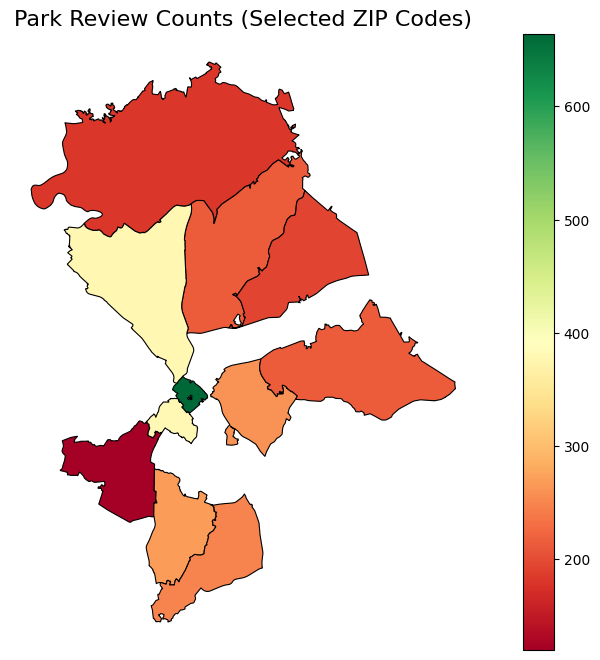

In [41]:
# 🗺️ Plot ZIP code review counts
fig, ax = plt.subplots(figsize=(12, 8))
gdf_filtered_merged.plot(
    column='Review Count',
    cmap='RdYlGn',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title("Park Review Counts (Selected ZIP Codes)", fontsize=16)
ax.axis('off')
plt.show()

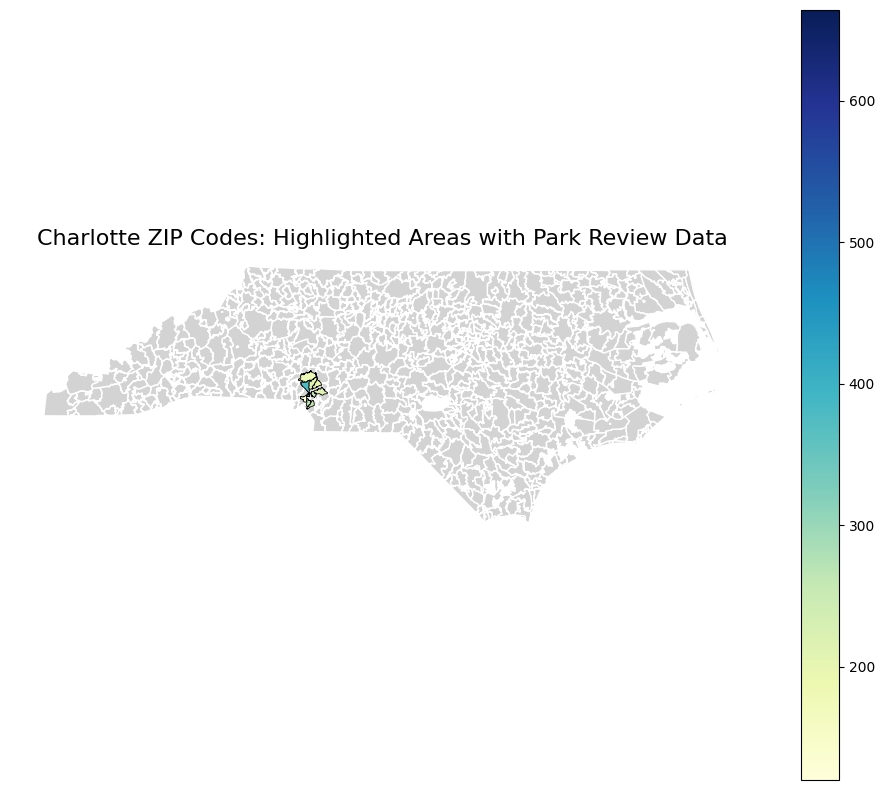

In [42]:
# 🗺️ Overlay selected ZIPs on the full Charlotte map background
fig, ax = plt.subplots(figsize=(12, 10))
gdf_zipcodes.plot(ax=ax, color='lightgray', edgecolor='white')

gdf_filtered_merged.plot(
    column='Review Count',
    cmap='YlGnBu',
    linewidth=0.6,
    edgecolor='black',
    legend=True,
    ax=ax
)

ax.set_title("Charlotte ZIP Codes: Highlighted Areas with Park Review Data", fontsize=16)
ax.axis('off')
plt.show()

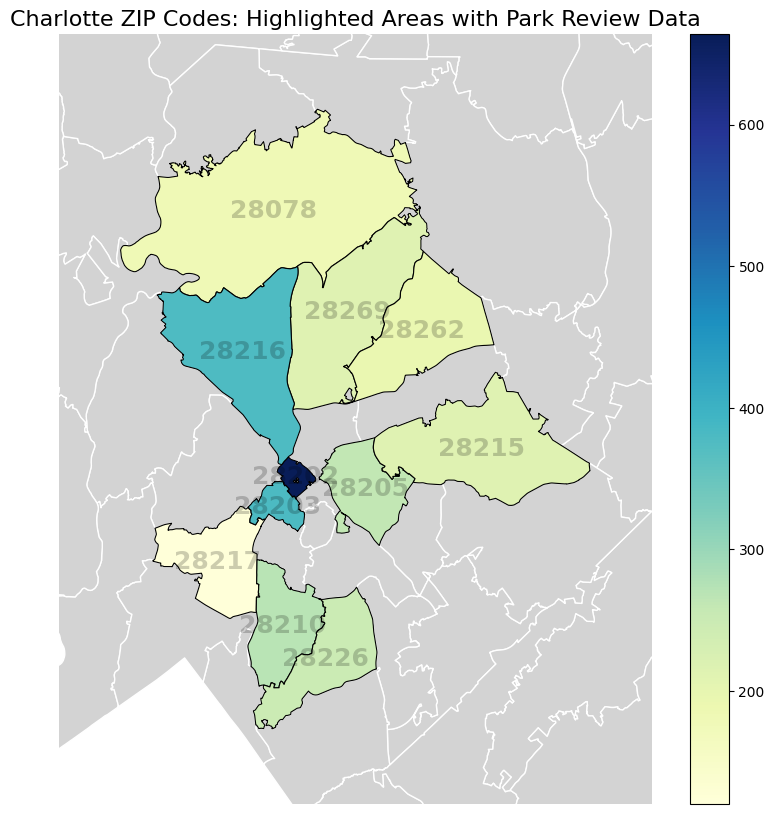

In [43]:
# 🖼️ Add ZIP code labels with watermark-style overlay
fig, ax = plt.subplots(figsize=(10, 10))
gdf_zipcodes.plot(ax=ax, color='lightgray', edgecolor='white')

gdf_filtered_merged.plot(
    column='Review Count',
    cmap='YlGnBu',
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    ax=ax
)

# Watermark labels at ZIP centroids
for _, row in gdf_filtered_merged.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    ax.text(
        x=row['geometry'].centroid.x,
        y=row['geometry'].centroid.y,
        s=row['ZCTA5CE10'],
        ha='center',
        va='center',
        fontsize=18,
        color='black',
        alpha=0.2,
        weight='bold'
    )

# Zoom in slightly to the Charlotte area
minx, miny, maxx, maxy = gdf_filtered_merged.total_bounds
ax.set_xlim(minx - 0.05, maxx + 0.05)
ax.set_ylim(miny - 0.05, maxy + 0.05)
ax.set_title("Charlotte ZIP Codes: Highlighted Areas with Park Review Data", fontsize=16)
ax.axis('off')
plt.show()

In [44]:
# 🏆 Group by ZIP + park name and count number of reviews per park
top_parks = (
    pr_cleaned.groupby(['Zip Code', 'Park Name'])
    .size()
    .reset_index(name='Review Count')
    .sort_values(['Zip Code', 'Review Count'], ascending=[True, False])
)

top_parks.head(16)  # Preview

,Zip Code,Park Name,Review Count
0,28078.0,R.C. Bradford Park,181
3,28202.0,Romare Bearden Park,292
1,28202.0,First Ward Park,200
2,28202.0,Fourth Ward Park,172
4,28203.0,Freedom Park,206
5,28203.0,Little Sugar Creek Greenway,174
6,28205.0,Eastway Park,171
7,28205.0,Midwood Park,91
8,28210.0,Park Road Park,269
9,28215.0,Reedy Creek Park,214


In [45]:
# 🚫 Remove rows where all fields are just newlines (e.g., parsing issues)
pr_cleaned = Park_review[Park_review.ne('\n').all(axis=1)]

# Reset the index after dropping
pr_cleaned.reset_index(drop=True, inplace=True)

# Inspect cleaned data
pr_cleaned.describe()

,Zip Code,Latitude,Longitude
count,3098.000000,2723.000000,2723.000000
mean,28209.295352,35.221416,-80.830112
std,38.457138,0.052691,0.057688
min,28078.000000,35.149155,-80.949979
25%,28202.000000,35.191535,-80.852529
50%,28210.000000,35.226837,-80.843443
75%,28216.000000,35.256605,-80.802971
max,28269.000000,35.319452,-80.715557


In [46]:
# 🔤 Remove emojis and unwanted characters from 'Review' column
review_clean = pd.DataFrame(pr_cleaned)
review_clean['Review'] = review_clean['Review'].apply(lambda x: re.sub(r'[^\w\s,]', '', str(x)))  # Basic cleanup

In [47]:
# 🔗 Merge rows that were mistakenly split (missing metadata)
last_valid_row = None

for i in range(1, len(review_clean)):
    if pd.isna(review_clean.loc[i, 'Name']) and pd.isna(review_clean.loc[i, 'Date']) and pd.isna(review_clean.loc[i, 'Park Name']):
        if last_valid_row is not None:
            review_clean.loc[last_valid_row, 'Review'] += " " + review_clean.loc[i, 'Review']
            review_clean.drop(index=i, inplace=True)
    else:
        last_valid_row = i

# Reset index after merge cleanup
review_clean.reset_index(drop=True, inplace=True)

In [48]:
# 🏞️ Extract list of all unique park names
unique_park_names = review_clean['Park Name'].dropna().unique()
unique_park_names = sorted(unique_park_names)

for name in unique_park_names:
    print(name)

unique_park_names_list = list(unique_park_names)

Clanton Park
Eastway Park
First Ward Park
Fourth Ward Park
Freedom Park
Hornets Nest Park
Little Sugar Creek Greenway
McAlpine Creek Park
Midwood Park
Nevin Park
Park Road Park
R.C. Bradford Park
Reedy Creek Park
Robert L. Smith Park
Romare Bearden Park
UNCC Botanical Garden


In [49]:
# 🧩 Create all contiguous word combinations from park names
park_names = ['Clanton Park', 'Eastway Park', 'First Ward Park', 'Fourth Ward Park', 'Freedom Park',
              'Hornets Nest Park', 'Little Sugar Creek Greenway', 'McAlpine Creek Park', 'Midwood Park',
              'Nevin Park', 'Park Road Park', 'R.C. Bradford Park', 'Reedy Creek Park', 'Robert L. Smith Park',
              'Romare Bearden Park', 'UNCC Botanical Garden']

def generate_contiguous_phrases(name):
    words = name.split()
    phrases = set()
    for start in range(len(words)):
        for end in range(start + 1, len(words) + 1):
            phrase = " ".join(words[start:end])
            phrases.add(phrase)
    return phrases

all_variants = set()
for park in park_names:
    all_variants.update(generate_contiguous_phrases(park))

all_variants = sorted(all_variants)

for variant in all_variants:
    print(variant)

Bearden
Bearden Park
Botanical
Botanical Garden
Bradford
Bradford Park
Clanton
Clanton Park
Creek
Creek Greenway
Creek Park
Eastway
Eastway Park
First
First Ward
First Ward Park
Fourth
Fourth Ward
Fourth Ward Park
Freedom
Freedom Park
Garden
Greenway
Hornets
Hornets Nest
Hornets Nest Park
L.
L. Smith
L. Smith Park
Little
Little Sugar
Little Sugar Creek
Little Sugar Creek Greenway
McAlpine
McAlpine Creek
McAlpine Creek Park
Midwood
Midwood Park
Nest
Nest Park
Nevin
Nevin Park
Park
Park Road
Park Road Park
R.C.
R.C. Bradford
R.C. Bradford Park
Reedy
Reedy Creek
Reedy Creek Park
Road
Road Park
Robert
Robert L.
Robert L. Smith
Robert L. Smith Park
Romare
Romare Bearden
Romare Bearden Park
Smith
Smith Park
Sugar
Sugar Creek
Sugar Creek Greenway
UNCC
UNCC Botanical
UNCC Botanical Garden
Ward
Ward Park


In [50]:
# 🚫 Remove park names from reviews to avoid skewing sentiment
def remove_park_names(text):
    for park in all_variants:
        text = re.sub(r'\b' + re.escape(park) + r'\b', '', text, flags=re.IGNORECASE)
    return text.strip()

review_clean['Review'] = review_clean['Review'].astype(str).apply(remove_park_names)

# Preview cleaned reviews
display(review_clean[['Review']].head(10))

,Review
0,", located in Uptown Charlotte, is a beautifull..."
1,Wow stunning well maintained horticulture c...
2,Its a beautiful part and I was blessed to expe...
3,What an amazing in Uptown Charlotte Big flat ...
4,"Great view , went there to see uptown Charlott..."
5,This had the best views of downtown since it ...
6,"in Charlotte, North Carolina is an absolute ge..."
7,This place is perfect for relaxation and unwin...
8,is a beautiful urban oasis Located in the hear...
9,Absolute beautiful Theres a huge field to pla...


In [ ]:
# 📝 Use TextBlob to automatically correct spelling
def correct_with_textblob(text):
    return str(TextBlob(text).correct())

# Apply to the cleaned 'Review' column
review_clean['Review_Corrected'] = review_clean['Review'].astype(str).apply(correct_with_textblob)

# Inspect output
display(review_clean)
review_clean.describe()

,Name,Date,Review,Park Name,Zip Code,Latitude,Longitude,Review_Corrected
0,Giovanni Cortes,2 months ago,", located in Uptown Charlotte, is a beautifull...",Romare Bearden Park,28202.0,35.226837,-80.847618,", located in Town Charlotte, is a beautifully ..."
1,LALITH KUMAR,6 months ago,Wow stunning well maintained horticulture c...,Romare Bearden Park,28202.0,35.226837,-80.847618,Now stunning well maintained horticulture c...
2,Garrett Myler,6 months ago,Its a beautiful part and I was blessed to expe...,Romare Bearden Park,28202.0,35.226837,-80.847618,Its a beautiful part and I was blessed to expe...
3,Bruce K.,11 months ago,What an amazing in Uptown Charlotte Big flat ...,Romare Bearden Park,28202.0,35.226837,-80.847618,That an amazing in Town Charlotte Fig flat gr...
4,Bala Subramanian,3 months ago,"Great view , went there to see uptown Charlott...",Romare Bearden Park,28202.0,35.226837,-80.847618,"Great view , went there to see upon Charlotte ..."
...,...,...,...,...,...,...,...,...
3093,Debbie Hinkle,5 years ago,Good,R.C. Bradford Park,28078.0,NaN,NaN,Good
3094,Dawn Day,7 years ago,Very nice facility,R.C. Bradford Park,28078.0,NaN,NaN,Very nice facility
3095,Kyle Martin,6 years ago,Fields arent the best,R.C. Bradford Park,28078.0,NaN,NaN,Fields agent the best
3096,Yiannis Kokolis,4 years ago,Great disc golf course,R.C. Bradford Park,28078.0,NaN,NaN,Great disc golf course


,Zip Code,Latitude,Longitude
count,3098.000000,2723.000000,2723.000000
mean,28209.295352,35.221416,-80.830112
std,38.457138,0.052691,0.057688
min,28078.000000,35.149155,-80.949979
25%,28202.000000,35.191535,-80.852529
50%,28210.000000,35.226837,-80.843443
75%,28216.000000,35.256605,-80.802971
max,28269.000000,35.319452,-80.715557


In [ ]:
# ❌ Remove stopwords (default + custom)
stop_words = set(stopwords.words('english'))
custom_stopwords = {
    "park", "charlotte", "one", "place", "get", "go", "the", "and", "a", "to", "of",
    "for", "is", "in", "it", "i", "around", "also", "vice"
}
stop_words.update(custom_stopwords)

def clean_words(word_list):
    return [word.lower() for word in word_list if word.lower() not in stop_words]

# Apply to the corrected review text
review_clean['Review_Corrected'] = review_clean['Review_Corrected'].astype(str).apply(
    lambda text: " ".join(clean_words(text.split()))
)

# Check result stats
print(review_clean['Review_Corrected'].describe())

count          3098
unique         2936
top       beautiful
freq             31
Name: Review_Corrected, dtype: object


In [ ]:
# 🔠 Analyze the most common words after stopword removal
words = pd.Series(" ".join(review_clean['Review_Corrected'].astype(str)).split()).str.lower()
most_common_words = words.value_counts().head(20)

print(most_common_words)

great         804
beautiful     585
nice          516
kiss          353
walk          349
area          321
good          318
well          317
love          294
play          279
disc          260
course        251
golf          243
family        239
trails        237
clean         237
walking       230
playground    227
lots          222
time          213
Name: count, dtype: int64


In [ ]:
# 🧠 Define synonym + multi-word mappings to normalize text
synonym_map = {
    "great": "good", "nice": "good", "awesome": "good", "fantastic": "good", "excellent": "good",
    "beautiful": "attractive", "pretty": "attractive", "gorgeous": "attractive",
    "clean": "clean", "tidy": "clean",
    "kids": "children", "kiss": "children", "kid": "children",
    "walking": "walk", "walked": "walk", "walks": "walk",
    "trails": "trail", "areas": "area", "courts": "court"
}

multiword_map = {
    "disc golf course": "disc_golf",
    "disc golf": "disc_golf",
    "disc wolf course": "disc_golf"
}


In [ ]:
# 🔁 Replace multi-word phrases first
def replace_multiword_phrases(text, multiword_map):
    text = text.lower()
    for phrase, replacement in multiword_map.items():
        text = text.replace(phrase, replacement)
    return text

# 🔄 Replace individual synonyms using regex tokenization
def replace_synonyms(text, synonym_map):
    text = text.lower()
    words = re.findall(r'\b\w+\b', text)
    replaced = [synonym_map.get(word, word) for word in words]
    return ' '.join(replaced)


In [ ]:
# ⚙️ Apply the mapping functions to cleaned reviews
review_clean['Review_MultiwordMapped'] = review_clean['Review_Corrected'].apply(lambda x: replace_multiword_phrases(x, multiword_map))
review_clean['Review_SynonymMapped'] = review_clean['Review_MultiwordMapped'].apply(lambda x: replace_synonyms(x, synonym_map))


In [ ]:
# 📊 Use TextBlob to extract sentiment polarity & subjectivity
def analyze_sentiment(text):
    blob = TextBlob(text)
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

# Apply to cleaned and normalized review text
review_clean[['Polarity', 'Subjectivity']] = review_clean['Review_SynonymMapped'].apply(analyze_sentiment)


In [ ]:
# 🚦 Categorize sentiment based on polarity thresholds
def classify_sentiment(polarity):
    if polarity > 0.25:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

# Assign sentiment labels
review_clean['Sentiment'] = review_clean['Polarity'].apply(classify_sentiment)

# Check sentiment distribution
print(review_clean['Sentiment'].value_counts())


Sentiment
Positive    2205
Neutral      770
Negative     123
Name: count, dtype: int64


In [ ]:
# 🏞️ Rank parks by average sentiment polarity
park_sentiment = review_clean.groupby('Park Name')['Polarity'].mean().sort_values(ascending=False)

print("Top 5 Happiest Parks:\n", park_sentiment.head(5))
print("\nTop 5 Most Criticized Parks:\n", park_sentiment.tail(5))


Top 5 Happiest Parks:
 Park Name
Freedom Park             0.444261
Romare Bearden Park      0.426114
Park Road Park           0.425815
R.C. Bradford Park       0.419121
UNCC Botanical Garden    0.407855
Name: Polarity, dtype: float64

Top 5 Most Criticized Parks:
 Park Name
Nevin Park              0.365859
First Ward Park         0.362755
Midwood Park            0.355334
Clanton Park            0.346161
Robert L. Smith Park    0.343346
Name: Polarity, dtype: float64


In [ ]:
# 🗣️ Identify top-used words in positive and negative reviews
positive_words = " ".join(review_clean[review_clean['Sentiment'] == "Positive"]['Review_SynonymMapped']).split()
negative_words = " ".join(review_clean[review_clean['Sentiment'] == "Negative"]['Review_SynonymMapped']).split()

positive_words_cleaned = clean_words(positive_words)
negative_words_cleaned = clean_words(negative_words)

positive_counts = Counter(positive_words_cleaned)
negative_counts = Counter(negative_words_cleaned)

print("Top Positive Words:\n", positive_counts.most_common(20))
print("\nTop Negative Words:\n", negative_counts.most_common(20))


Top Positive Words:
 [('good', 1708), ('attractive', 664), ('walk', 508), ('children', 385), ('area', 339), ('trail', 306), ('love', 246), ('clean', 242), ('well', 228), ('family', 213), ('play', 202), ('playground', 176), ('enjoy', 162), ('time', 157), ('lots', 148), ('disc_golf', 144), ('really', 140), ('take', 139), ('fun', 137), ('picnic', 136)]

Top Negative Words:
 [('people', 26), ('area', 24), ('walk', 21), ('small', 21), ('parking', 19), ('disc_golf', 19), ('children', 17), ('dog', 16), ('lot', 11), ('lots', 10), ('plenty', 10), ('trail', 10), ('dogs', 10), ('homeless', 10), ('really', 9), ('well', 9), ('like', 9), ('bathroom', 9), ('play', 9), ('trash', 9)]


In [ ]:
# 📚 Extract frequent 2-word and 4-word phrases by sentiment class
def extract_ngrams_by_sentiment(df, column_name, sentiment_column):
    bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    trigram_vectorizer = CountVectorizer(ngram_range=(4, 4), stop_words='english')
    ngram_results = {}

    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_reviews = df[df[sentiment_column] == sentiment][column_name].dropna().tolist()

        bigram_matrix = bigram_vectorizer.fit_transform(sentiment_reviews)
        trigram_matrix = trigram_vectorizer.fit_transform(sentiment_reviews)

        bigram_counts = pd.DataFrame(bigram_matrix.toarray(), columns=bigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
        trigram_counts = pd.DataFrame(trigram_matrix.toarray(), columns=trigram_vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

        ngram_results[sentiment] = {
            'Top 10 Bigrams': bigram_counts.head(10),
            'Top 10 Trigrams': trigram_counts.head(10)
        }

    return ngram_results

# Run and print results
ngram_analysis = extract_ngrams_by_sentiment(review_clean, 'Review_SynonymMapped', 'Sentiment')

for sentiment, results in ngram_analysis.items():
    print(f"Top Bigrams and Trigrams for {sentiment} Reviews:\n")
    print("Top 10 Bigrams:\n", results['Top 10 Bigrams'])
    print("\nTop 10 Trigrams:\n", results['Top 10 Trigrams'])
    print("\n" + "="*40 + "\n")


Top Bigrams and Trigrams for Positive Reviews:

Top 10 Bigrams:
 good walk           130
walk trail           75
really good          57
good children        50
basketball court     44
good disc_golf       40
good good            40
children play        39
good family          38
play area            36
dtype: int64

Top 10 Trigrams:
 tennis court basketball court    3
attractive good walk trail       2
trees plants plus sign           2
picnic area clean restrooms      2
beauty definitely worth visit    2
plenty benches sit enjoy         2
walk dog children play           2
good walk trail good             2
walk run bike ride               2
water features children play     2
dtype: int64


Top Bigrams and Trigrams for Negative Reviews:

Top 10 Bigrams:
 green space         3
homeless people     3
tennis court        3
20 les              3
basketball court    3
parking lot         3
hidden gem          3
public library      3
soccer fields       2
dogs 20             2
dtype: int64


In [ ]:
# ⚠️ Words that may indicate sentiment but lack specific action/context
general_sentiment_words = {
    "good", "nice", "great", "awesome", "fun", "enjoy", "really",
    "fantastic", "excellent", "beautiful", "attractive", "neat",
    "love", "like", "well", "lot", "lots", "time", "really", "perfect", "liking", "area", "play"
}


In [ ]:
# 🎯 Remove overly generic sentiment terms to focus on descriptive features
def remove_general_words(text, words_to_remove):
    tokens = text.lower().split()
    filtered = [word for word in tokens if word not in words_to_remove]
    return " ".join(filtered)

# Apply to the synonym-mapped review column
review_clean['Review_FeatureFocus'] = review_clean['Review_SynonymMapped'].apply(
    lambda x: remove_general_words(x, general_sentiment_words)
)


In [ ]:
# 🧱 Analyze bigrams and trigrams in filtered feature-focused reviews

# Top bigrams
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=20)
X_bigrams = bigram_vectorizer.fit_transform(review_clean['Review_FeatureFocus'])
bigram_counts = X_bigrams.sum(axis=0).A1
bigrams = bigram_vectorizer.get_feature_names_out()
bigram_freq = pd.Series(bigram_counts, index=bigrams).sort_values(ascending=False)
print("Top Feature Bigrams:")
print(bigram_freq)

# Top trigrams
trigram_vectorizer = CountVectorizer(ngram_range=(4, 4), max_features=20)
X_trigrams = trigram_vectorizer.fit_transform(review_clean['Review_FeatureFocus'])
trigram_counts = X_trigrams.sum(axis=0).A1
trigrams = trigram_vectorizer.get_feature_names_out()
trigram_freq = pd.Series(trigram_counts, index=trigrams).sort_values(ascending=False)
print("\nTop Feature Trigrams:")
print(trigram_freq)


Top Feature Bigrams:
walk trail             108
basketball court        65
splash pad              44
playground children     40
picnic tables           37
soccer fields           31
tennis court            31
walk dog                27
take children           25
highly recommend        25
plenty parking          24
trail walk              22
fresh air               22
nature center           21
baseball field          20
plenty space            20
cross country           19
children playground     19
homeless people         19
walk run                18
dtype: int64

Top Feature Trigrams:
basketball court baseball fields    4
basketball court tennis court       4
tennis court basketball court       4
right next light rail               3
plants plus sign hut                2
picnic tables basketball court      2
rental exercise box children        2
plenty space outdoor activities     2
soccer field baseball field         2
spend day wandering different       2
spot walk dog take     

<ipython-input-65-e6515fbc37d6>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_parks, x='Review Count', y='Park Name', palette='RdYlGn')


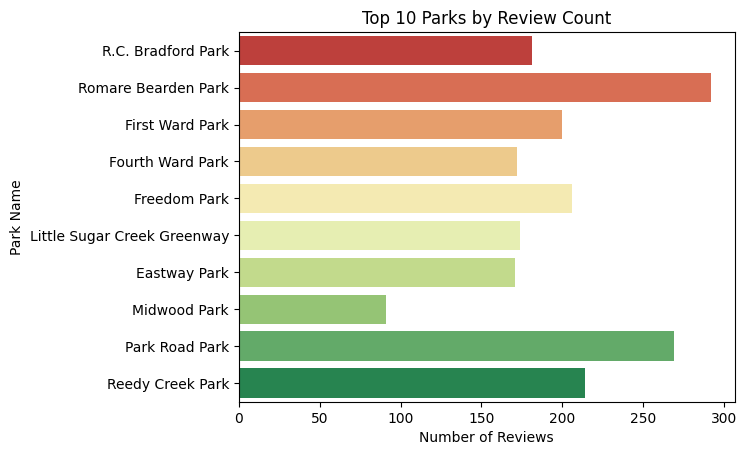

In [ ]:
# 📊 Visualize parks with the most reviews
top_10_parks = top_parks.head(10)

sns.barplot(data=top_10_parks, x='Review Count', y='Park Name', palette='RdYlGn')
plt.title('Top 10 Parks by Review Count')
plt.xlabel('Number of Reviews')
plt.ylabel('Park Name')
plt.show()


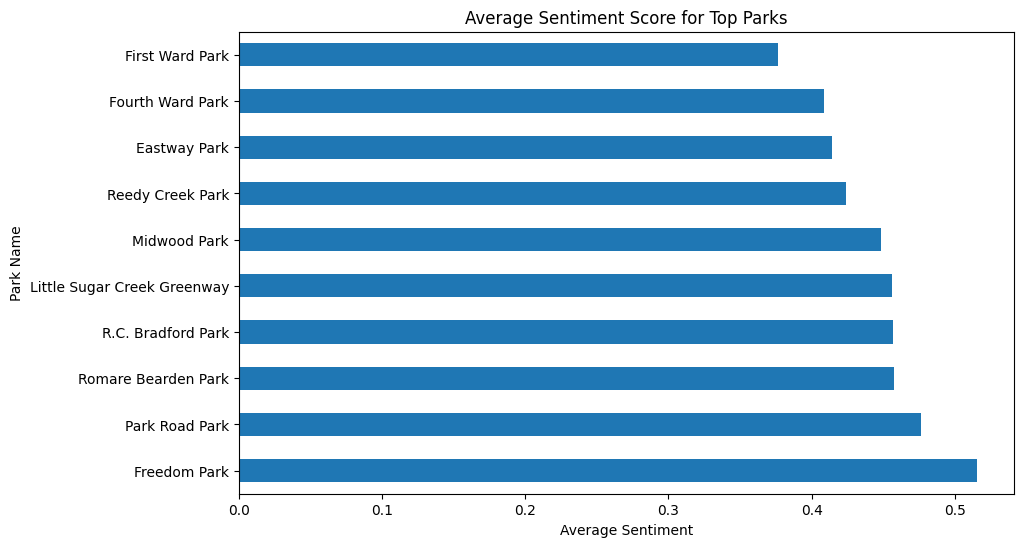

In [ ]:
# 😊 Compare average sentiment across the most reviewed parks
top_park_names = top_parks['Park Name'].unique()[:10]
top_park_reviews = pr_cleaned[pr_cleaned['Park Name'].isin(top_park_names)].copy()

top_park_reviews['Sentiment'] = top_park_reviews['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)

sentiment_summary = top_park_reviews.groupby('Park Name')['Sentiment'].mean().sort_values(ascending=False)

sentiment_summary.plot(kind='barh', figsize=(10,6))
plt.title('Average Sentiment Score for Top Parks')
plt.xlabel('Average Sentiment')
plt.ylabel('Park Name')
plt.show()


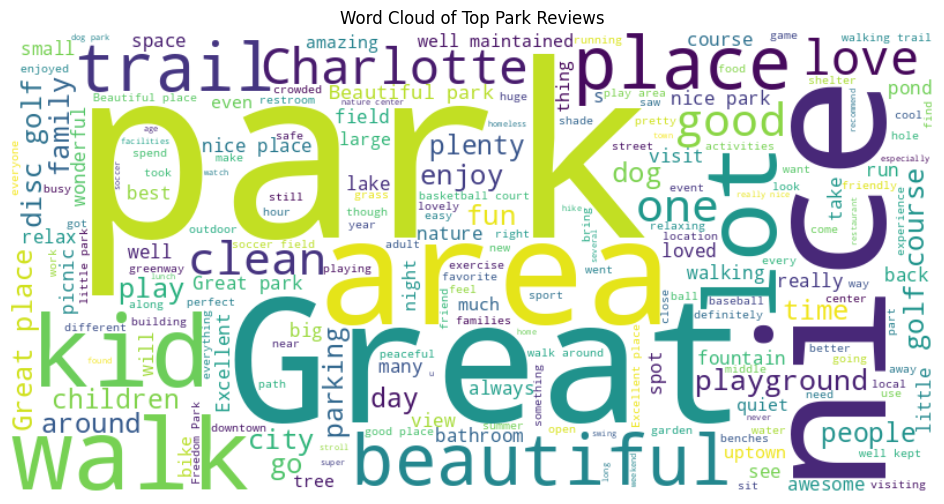

In [ ]:
# ☁️ Create a word cloud from top park reviews
text = ' '.join(top_park_reviews['Review'].dropna())

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Park Reviews')
plt.show()


In [ ]:
# 🗺️ Create an interactive Folium map with ZIP-level review data
m_interactive = folium.Map(location=[35.2271, -80.8431], zoom_start=11)  # Charlotte center

for _, row in gdf_filtered_merged.iterrows():
    centroid = row['geometry'].centroid
    folium.Marker(
        location=[centroid.y, centroid.x],
        popup=f"ZIP: {row['ZCTA5CE10']}<br>Reviews: {row['Review Count']}"
    ).add_to(m_interactive)

m_interactive

In [ ]:
# ✅ Prepare dataset for clustering
park_data = (
    Park_review
    .dropna(subset=['Latitude', 'Longitude'])
    .groupby(['Park Name', 'Latitude', 'Longitude'])
    .size()
    .reset_index(name='Review_Count')
)

# Now min_count and max_count will work correctly
min_count = park_data['Review_Count'].min()
max_count = park_data['Review_Count'].max()


In [ ]:

# Generate color scale and base map
min_count = park_data['Review_Count'].min()
max_count = park_data['Review_Count'].max()
review_colormap = cm.linear.viridis.scale(min_count, max_count)
review_colormap.caption = 'Review Count (Color)'

m_cluster = folium.Map(location=[35.2271, -80.8431], zoom_start=11)
marker_cluster = MarkerCluster().add_to(m_cluster)

# Add CircleMarkers for each park
for _, row in park_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=np.sqrt(row['Review_Count']) * 1.5,
        color=review_colormap(row['Review_Count']),
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(
            f"Park: {row['Park Name']}<br>Reviews: {row['Review_Count']}",
            max_width=250
        )
    ).add_to(marker_cluster)

# Add color legend and save output
review_colormap.add_to(m_cluster)
m_cluster


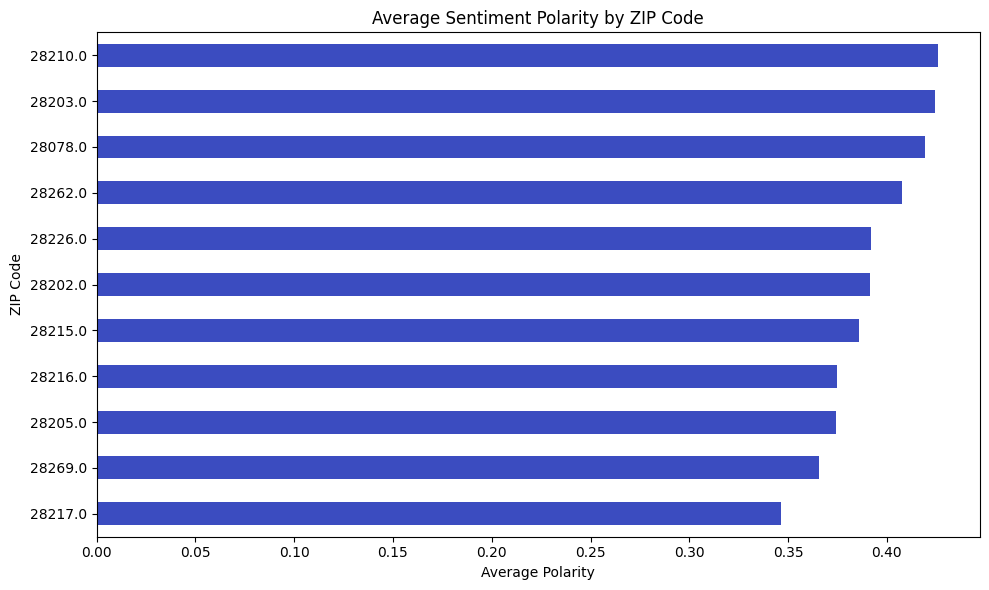

In [ ]:
# 📏 Sort and plot average polarity by ZIP
zip_avg_sentiment = review_clean.groupby('Zip Code')['Polarity'].mean().sort_values()

plt.figure(figsize=(10, 6))
zip_avg_sentiment.plot(kind='barh', colormap='coolwarm')
plt.title('Average Sentiment Polarity by ZIP Code')
plt.xlabel('Average Polarity')
plt.ylabel('ZIP Code')
plt.tight_layout()
plt.show()


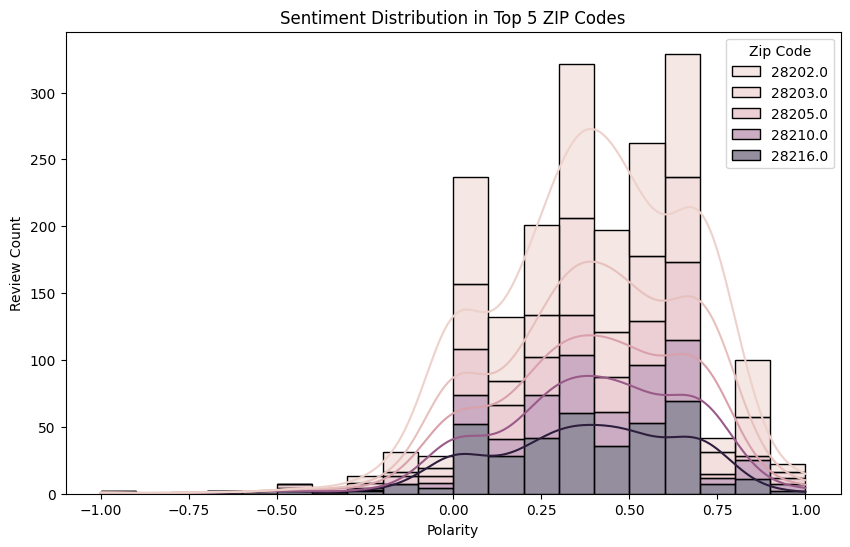

In [ ]:
# 📉 Histogram of sentiment for selected ZIP codes
top_zips = review_clean['Zip Code'].value_counts().head(5).index.tolist()
filtered = review_clean[review_clean['Zip Code'].isin(top_zips)]

plt.figure(figsize=(10, 6))
sns.histplot(data=filtered, x='Polarity', hue='Zip Code', bins=20, kde=True, multiple='stack')
plt.title("Sentiment Distribution in Top 5 ZIP Codes")
plt.xlabel("Polarity")
plt.ylabel("Review Count")
plt.show()


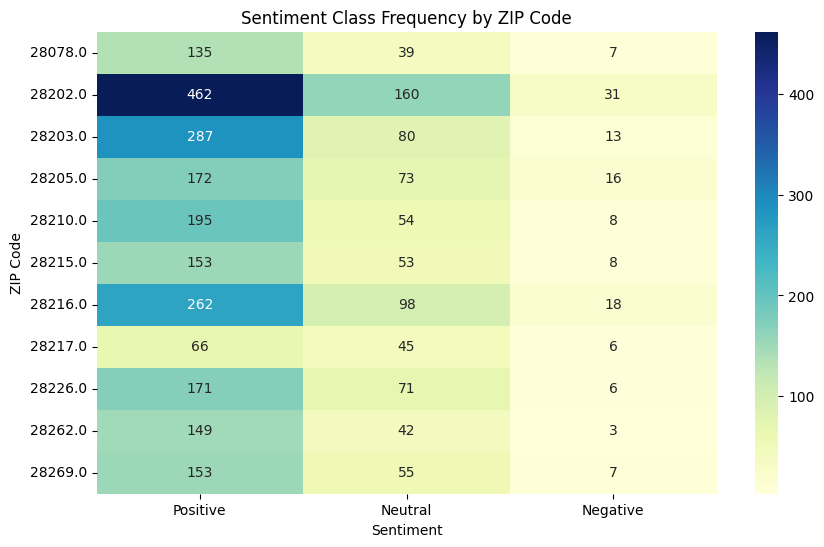

In [ ]:
# 📊 Create a ZIP × Sentiment matrix
heatmap_data = (
    review_clean.groupby(['Zip Code', 'Sentiment'])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=['Positive', 'Neutral', 'Negative'])
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Sentiment Class Frequency by ZIP Code")
plt.ylabel("ZIP Code")
plt.xlabel("Sentiment")
plt.show()


<ipython-input-74-fad786f4aba9>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zip_sentiment_avg, x='Zip Code', y='Polarity', palette='coolwarm')


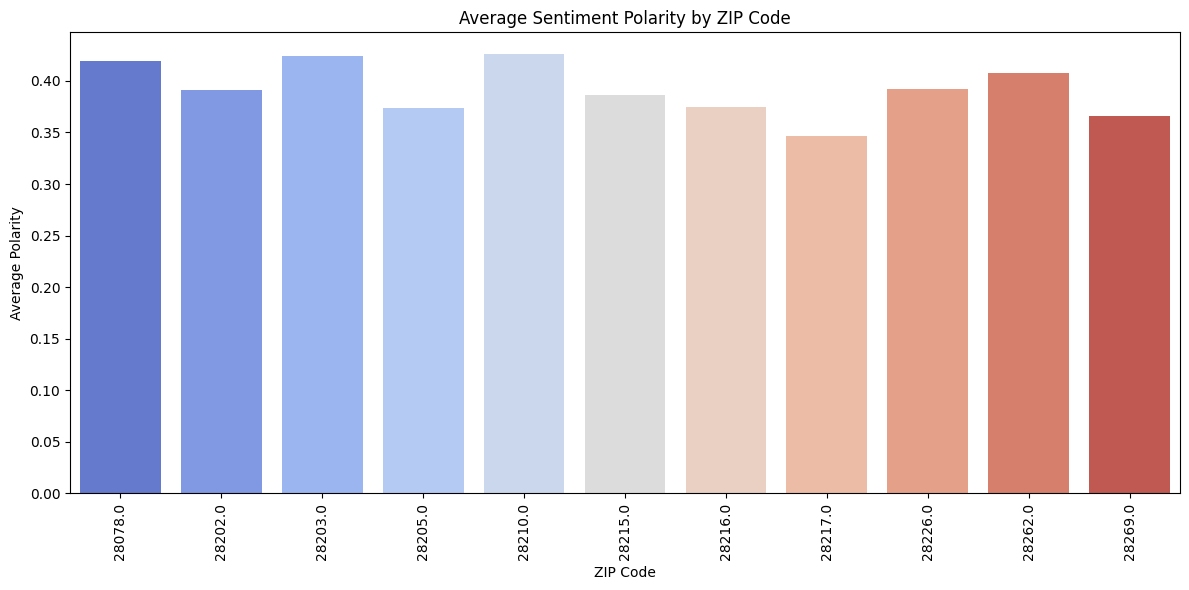

In [ ]:
zip_sentiment_avg = review_clean.groupby('Zip Code')['Polarity'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=zip_sentiment_avg, x='Zip Code', y='Polarity', palette='coolwarm')
plt.title("Average Sentiment Polarity by ZIP Code")
plt.xlabel("ZIP Code")
plt.ylabel("Average Polarity")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<ipython-input-75-03e4e157ed9c>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=zip_sentiment_std, x='Zip Code', y='Polarity', palette='RdYlGn')


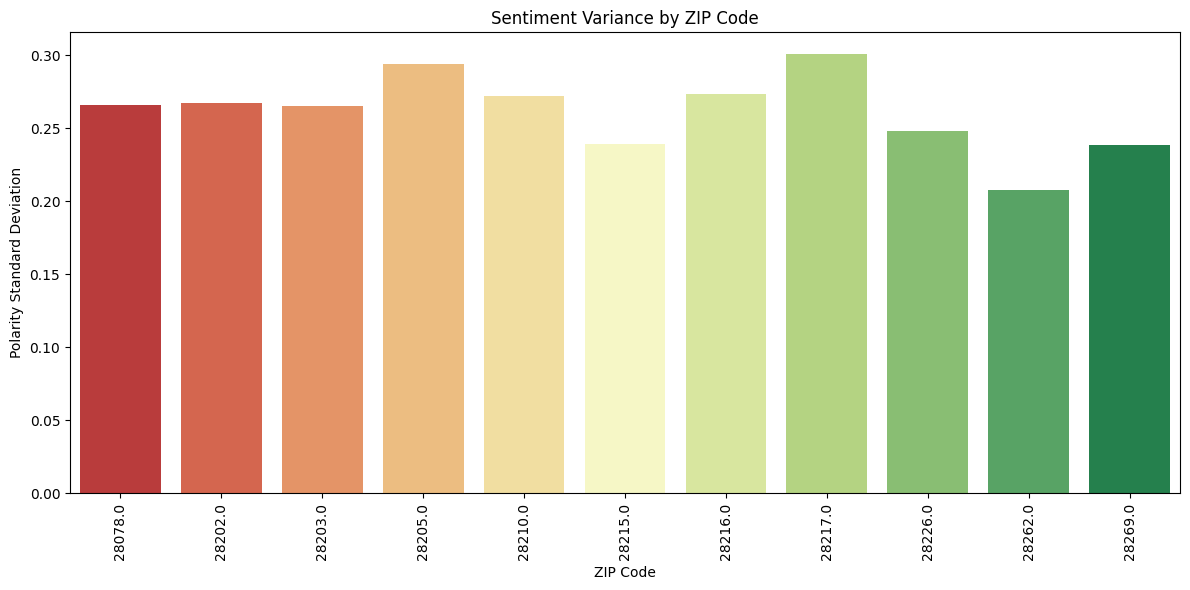

In [ ]:
zip_sentiment_std = review_clean.groupby('Zip Code')['Polarity'].std().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=zip_sentiment_std, x='Zip Code', y='Polarity', palette='RdYlGn')
plt.title("Sentiment Variance by ZIP Code")
plt.xlabel("ZIP Code")
plt.ylabel("Polarity Standard Deviation")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Ensure ZIP codes are string for comparison
review_clean['Zip Code'] = review_clean['Zip Code'].astype('Int64').astype(str)

# Select a ZIP code to analyze
zip_example = '28202'
reviews_subset = review_clean[review_clean['Zip Code'] == zip_example]['Review'].dropna()

# Extra check to avoid empty TF-IDF input
if not reviews_subset.empty:
    tfidf = TfidfVectorizer(stop_words='english', max_features=10)
    tfidf_matrix = tfidf.fit_transform(reviews_subset)

    if tfidf_matrix.shape[1] > 0:
        top_keywords = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
        print("Top Keywords in ZIP", zip_example)
        print(top_keywords.sum().sort_values(ascending=False))
    else:
        print(f"No significant keywords found in ZIP {zip_example} — too many stopwords or too short.")
else:
    print(f"No reviews available for ZIP {zip_example}")



Top Keywords in ZIP 28202
nice         121.611218
beautiful    112.550949
place        110.935802
great         83.120804
charlotte     63.645981
city          55.746023
area          52.058841
kids          46.866545
people        46.565950
walk          45.953235
dtype: float64


In [ ]:

corpus = review_clean['Review'].dropna()

vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=3)
X = vectorizer.fit_transform(corpus)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([words[i] for i in topic.argsort()[:-11:-1]])
    print()


In [ ]:
# Define the topic labels dictionary
topic_labels = {
    0: "Recreation & Trails",
    1: "Family & Amenities",
    2: "Nature & Scenery",
    3: "Playgrounds & Sports",
    4: "Relaxation & Urban Use"
}



In [ ]:
# Transform your document-term matrix into topic distributions
topic_distributions = lda.transform(X)  # X is your CountVectorizer output

# Get the dominant topic index for each review
dominant_topics = topic_distributions.argmax(axis=1)

# Attach dominant topics to your review_clean DataFrame
review_clean = review_clean.reset_index(drop=True)  # Ensure alignment
review_clean['Dominant Topic'] = dominant_topics

# (Optional) Attach the topic labels too
review_clean['Topic Label'] = review_clean['Dominant Topic'].map(topic_labels)


In [ ]:
# Step 1: Extract top words per topic from the LDA model
words = vectorizer.get_feature_names_out()
topic_word_lists = []

for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    topic_word_lists.append(top_words)
    print(f"Topic {topic_idx + 1}:", top_words)


In [ ]:
from wordcloud import WordCloud

# Step 2: Create word clouds
for i, topic_words in enumerate(topic_word_lists):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(topic_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i+1} Word Cloud")
    plt.show()


In [ ]:
# Ensure ZIP codes are strings
review_clean['Zip Code'] = review_clean['Zip Code'].astype('Int64').astype(str)

# Store results in a list
tfidf_results = []

# Group by ZIP code and run TF-IDF on each
for zip_code, group in review_clean.groupby('Zip Code'):
    reviews_subset = group['Review'].dropna()

    # Only analyze if there are enough non-empty reviews
    if len(reviews_subset) > 5:
        tfidf = TfidfVectorizer(stop_words='english', max_features=10)
        tfidf_matrix = tfidf.fit_transform(reviews_subset)

        if tfidf_matrix.shape[1] > 0:
            tfidf_scores = tfidf_matrix.sum(axis=0).A1
            keywords = tfidf.get_feature_names_out()
            zip_keywords = list(zip([zip_code]*len(keywords), keywords, tfidf_scores))
            tfidf_results.extend(zip_keywords)

# Convert results into a DataFrame
tfidf_df = pd.DataFrame(tfidf_results, columns=["Zip Code", "Keyword", "Score"])

# Sort and view top keywords by ZIP
tfidf_df.sort_values(['Zip Code', 'Score'], ascending=[True, False], inplace=True)
tfidf_df.head(50)


In [ ]:
# Classify sentiment
def classify_sentiment(p):
    if p >= 0.25:
        return 'Positive'
    elif p <= -0.01:
        return 'Negative'
    else:
        return 'Neutral'

review_clean['Sentiment_Category'] = review_clean['Polarity'].apply(classify_sentiment)

# Get sentiment counts per ZIP
sentiment_counts = review_clean.groupby(['Zip Code', 'Sentiment_Category']).size().unstack(fill_value=0)

# Calculate total and proportions
sentiment_counts['Total'] = sentiment_counts.sum(axis=1)
for col in ['Positive', 'Neutral', 'Negative']:
    sentiment_counts[f'{col}_Prop'] = sentiment_counts[col] / sentiment_counts['Total']

# Z-score each proportion
for col in ['Positive_Prop', 'Neutral_Prop', 'Negative_Prop']:
    sentiment_counts[f'{col}_zscore'] = zscore(sentiment_counts[col])

# Flag anomalies (z > 2 or z < -2)
def flag_anomalies(row):
    return any(abs(row[f'{col}_zscore']) > 2 for col in ['Positive_Prop', 'Neutral_Prop', 'Negative_Prop'])

sentiment_counts['Anomaly'] = sentiment_counts.apply(flag_anomalies, axis=1)

# View anomalies
anomalies = sentiment_counts[sentiment_counts['Anomaly']]
print("Anomalous ZIPs:")
print(anomalies[['Positive_Prop_zscore', 'Neutral_Prop_zscore', 'Negative_Prop_zscore']])


In [ ]:
# Ensure ZIP codes are strings
sentiment_counts = sentiment_counts.reset_index()
sentiment_counts['Zip Code'] = sentiment_counts['Zip Code'].astype(str)
gdf_sentiment = gdf_filtered_merged.merge(sentiment_counts, on='Zip Code', how='left')

import folium
from folium import Choropleth, LayerControl
from folium.plugins import MarkerCluster

# Create base map centered on Charlotte area
m = folium.Map(location=[35.2271, -80.8431], zoom_start=10)

# Add ZIP outlines
folium.GeoJson(
    gdf_sentiment,
    style_function=lambda x: {
        'fillColor': 'red' if x['properties']['Anomaly'] else 'green',
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(fields=['Zip Code'])
).add_to(m)

m.save("anomaly_map.html")
m


In [ ]:
# Make sure Zip Code is a column, not an index
anomaly_subset = sentiment_counts[sentiment_counts['Anomaly']].reset_index()

# Melt the data for seaborn
melted = anomaly_subset[['Zip Code', 'Positive_Prop', 'Neutral_Prop', 'Negative_Prop']].melt(
    id_vars='Zip Code', var_name='Sentiment', value_name='Proportion'
)

# Sort ZIPs to keep plot readable
zip_order = anomaly_subset.sort_values(by='Positive_Prop', ascending=False)['Zip Code']

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=melted, x='Zip Code', y='Proportion', hue='Sentiment', order=zip_order)
plt.title("Sentiment Proportions by ZIP Code (Anomalies)")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Sentiment')
plt.show()



In [ ]:
# Prepare data
X = review_clean['Review']
y = review_clean['Sentiment_Category']

# Vectorize the text using TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=3000)
X_tfidf = tfidf.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['Positive', 'Neutral', 'Negative'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Neutral', 'Negative'],
            yticklabels=['Positive', 'Neutral', 'Negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:

# Get feature names and model coefficients
feature_names = tfidf.get_feature_names_out()
coefficients = model.coef_  # Shape: (3 classes, number of features)
classes = model.classes_

# Show top N features for each class
top_n = 15
for i, sentiment in enumerate(classes):
    print(f"\nTop {top_n} words for class: {sentiment}")
    top_indices = np.argsort(coefficients[i])[-top_n:][::-1]  # Descending order
    for index in top_indices:
        print(f"{feature_names[index]}: {coefficients[i][index]:.4f}")


In [ ]:

# Number of top features per class to display
top_n = 15

# Set up feature names and coefficients
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_
classes = model.classes_

# Create a plot for each sentiment class
for i, sentiment in enumerate(classes):
    # Get top N words and their weights
    top_indices = np.argsort(coefs[i])[-top_n:]
    top_words = [feature_names[idx] for idx in top_indices]
    top_weights = coefs[i][top_indices]

    # Create bar plot
    plt.figure(figsize=(8, 6))
    plt.barh(top_words, top_weights, color='skyblue')
    plt.xlabel("Weight")
    plt.title(f"Top {top_n} Words for Class: {sentiment}")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
# Make sure 'Zip Code' is a string and set it as the index
sentiment_counts['Zip Code'] = sentiment_counts['Zip Code'].astype(str)
sentiment_counts.set_index('Zip Code', inplace=True)


In [ ]:
# Ensure the index is a string
sentiment_counts.index = sentiment_counts.index.astype(str)


zip_28217 = sentiment_counts.loc['28217', ['Positive_Prop', 'Neutral_Prop', 'Negative_Prop']]

# Get overall average
avg_props = sentiment_counts[['Positive_Prop', 'Neutral_Prop', 'Negative_Prop']].mean()

# Create DataFrame for plotting
comparison_df = pd.DataFrame({
    'ZIP 28217': zip_28217,
    'Average': avg_props
}).T  # Transpose to get sentiment types as columns

# Plot
comparison_df.plot(kind='bar', figsize=(8, 5), color=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
